In [71]:
# utility
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import norm, probplot
import matplotlib.pyplot as plt
import seaborn as sns

dataset = arff.loadarff('./data/ames_housing.arff')
data = pd.DataFrame(dataset[0])

print("Number of rows in the data:", data.shape[0])
print("Number of columns in the data:", data.shape[1])

Number of rows in the data: 2930
Number of columns in the data: 81


## First data engineering
We drop Pool_Qc feature, beacuse is information is already described by the feature Pool_Area

In [72]:
data = data.drop(labels='Pool_QC', axis=1)

# Refine data

In [73]:
#TODO: controllare 'fair', 'Typical'
def refineData(df):
    replace = {
        "Kitchen_Qual": {b'Poor': 0, b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Utilities": {b'AllPub': 1, b'NoSewr': 2, b'NoSeWa': 3},
        "Land_Slope": {b'Gtl': 1, b'Mod': 2, b'Sev': 3},
        "Overall_Qual": {b'Very_Poor': 1, b'Poor': 2, b'Below_Average': 3, b'Average': 4, b'Above_Average': 5,
                         b'Fair': 6, b'Good': 7, b'Very_Good': 8, b'Excellent': 9, b'Very_Excellent': 10},
        "Overall_Cond": {b'Very_Poor': 1, b'Poor': 2, b'Below_Average': 3, b'Average': 4, b'Above_Average': 5,
                         b'Fair': 6, b'Good': 7, b'Very_Good': 8, b'Excellent': 9, b'Very_Excellent': 10},
        "Exter_Qual": {b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Exter_Cond": {b'Poor': 1, b'Fair': 2, b'Typical': 3, b'Good': 4, b'Excellent': 4},
    }
    new_data = df.replace(replace)
    return new_data


data = refineData(data)

Neighborhood va sistemata????

<AxesSubplot: xlabel='Neighborhood', ylabel='Sale_Price'>

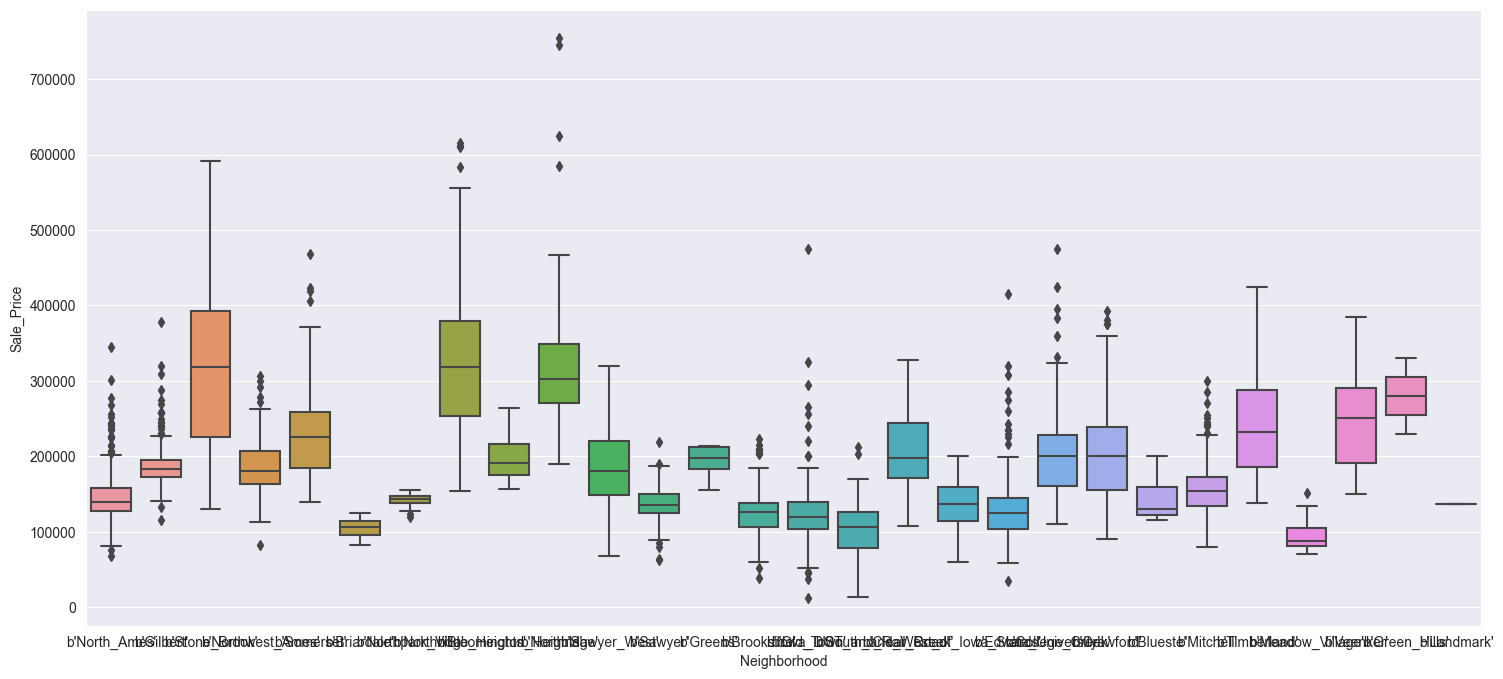

In [74]:
plt.figure(figsize=(18, 8))
sns.boxplot(x=data.Neighborhood, y=data.Sale_Price)

## Make data split


In [75]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Sale_Price'])
Y = data['Sale_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2344, 79), (586, 79), (2344,), (586,))

## One hot encoding
We are going to OneHotEncode the discrete variable

In [76]:
from sklearn.preprocessing import OneHotEncoder

X_train_numerical = X_train.select_dtypes(include=np.number)
X_test_numerical = X_test.select_dtypes(include=np.number)

categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

oh = OneHotEncoder(sparse=False, handle_unknown='ignore', min_frequency=0.15, max_categories=5)
oh.fit(X_train[categorical_columns])

X_train_e = oh.transform(X_train[categorical_columns])
X_test_e = oh.transform(X_test[categorical_columns])

for i, col in enumerate(oh.get_feature_names_out()):
    X_train_numerical[col] = X_train_e[:, i]

for i, col in enumerate(oh.get_feature_names_out()):
    X_test_numerical[col] = X_test_e[:, i]

#TODO we can try to defragment dataframe

X_train = X_train_numerical
X_test = X_test_numerical

X_train.shape, X_test.shape

((2344, 136), (586, 136))

# Studio della correlazione

Top 50% Corralation train attributes with sale-price

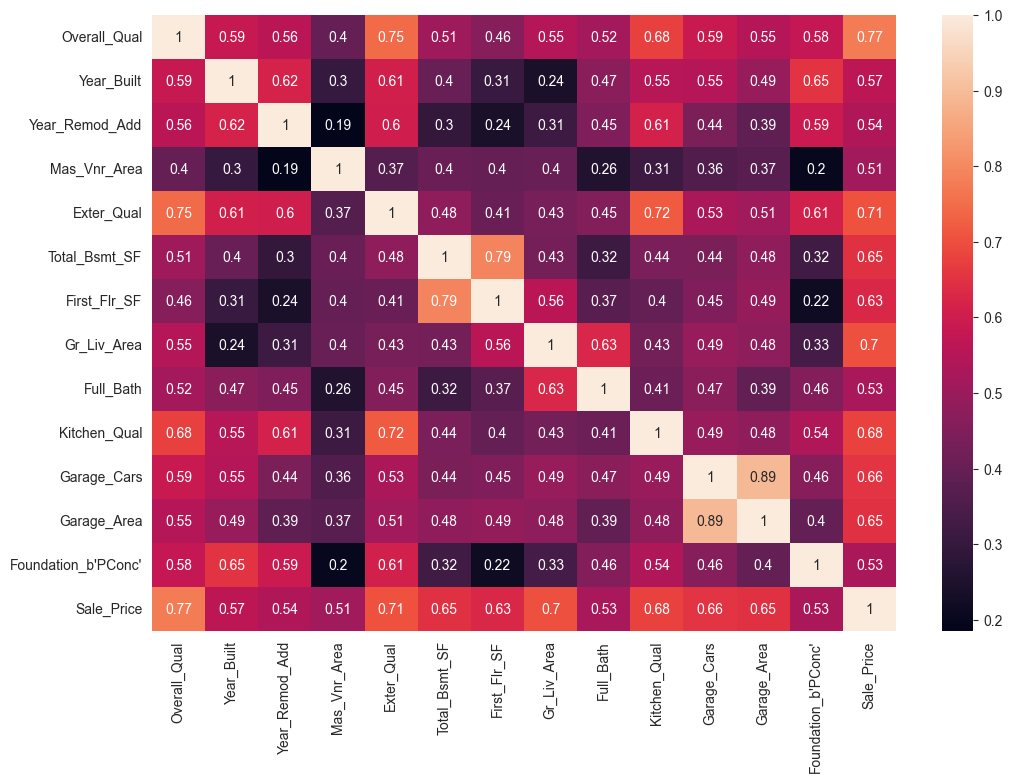

In [77]:
XY_train = pd.concat([X_train, Y_train], axis=1)
corr = XY_train.corr()

top_feature = corr.index[abs(corr['Sale_Price']) > 0.5]
plt.subplots(figsize=(12, 8))
top_corr = XY_train[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

griglia di plot che ci aiuta a vedere se vi è multicolinearità tra alcune feature

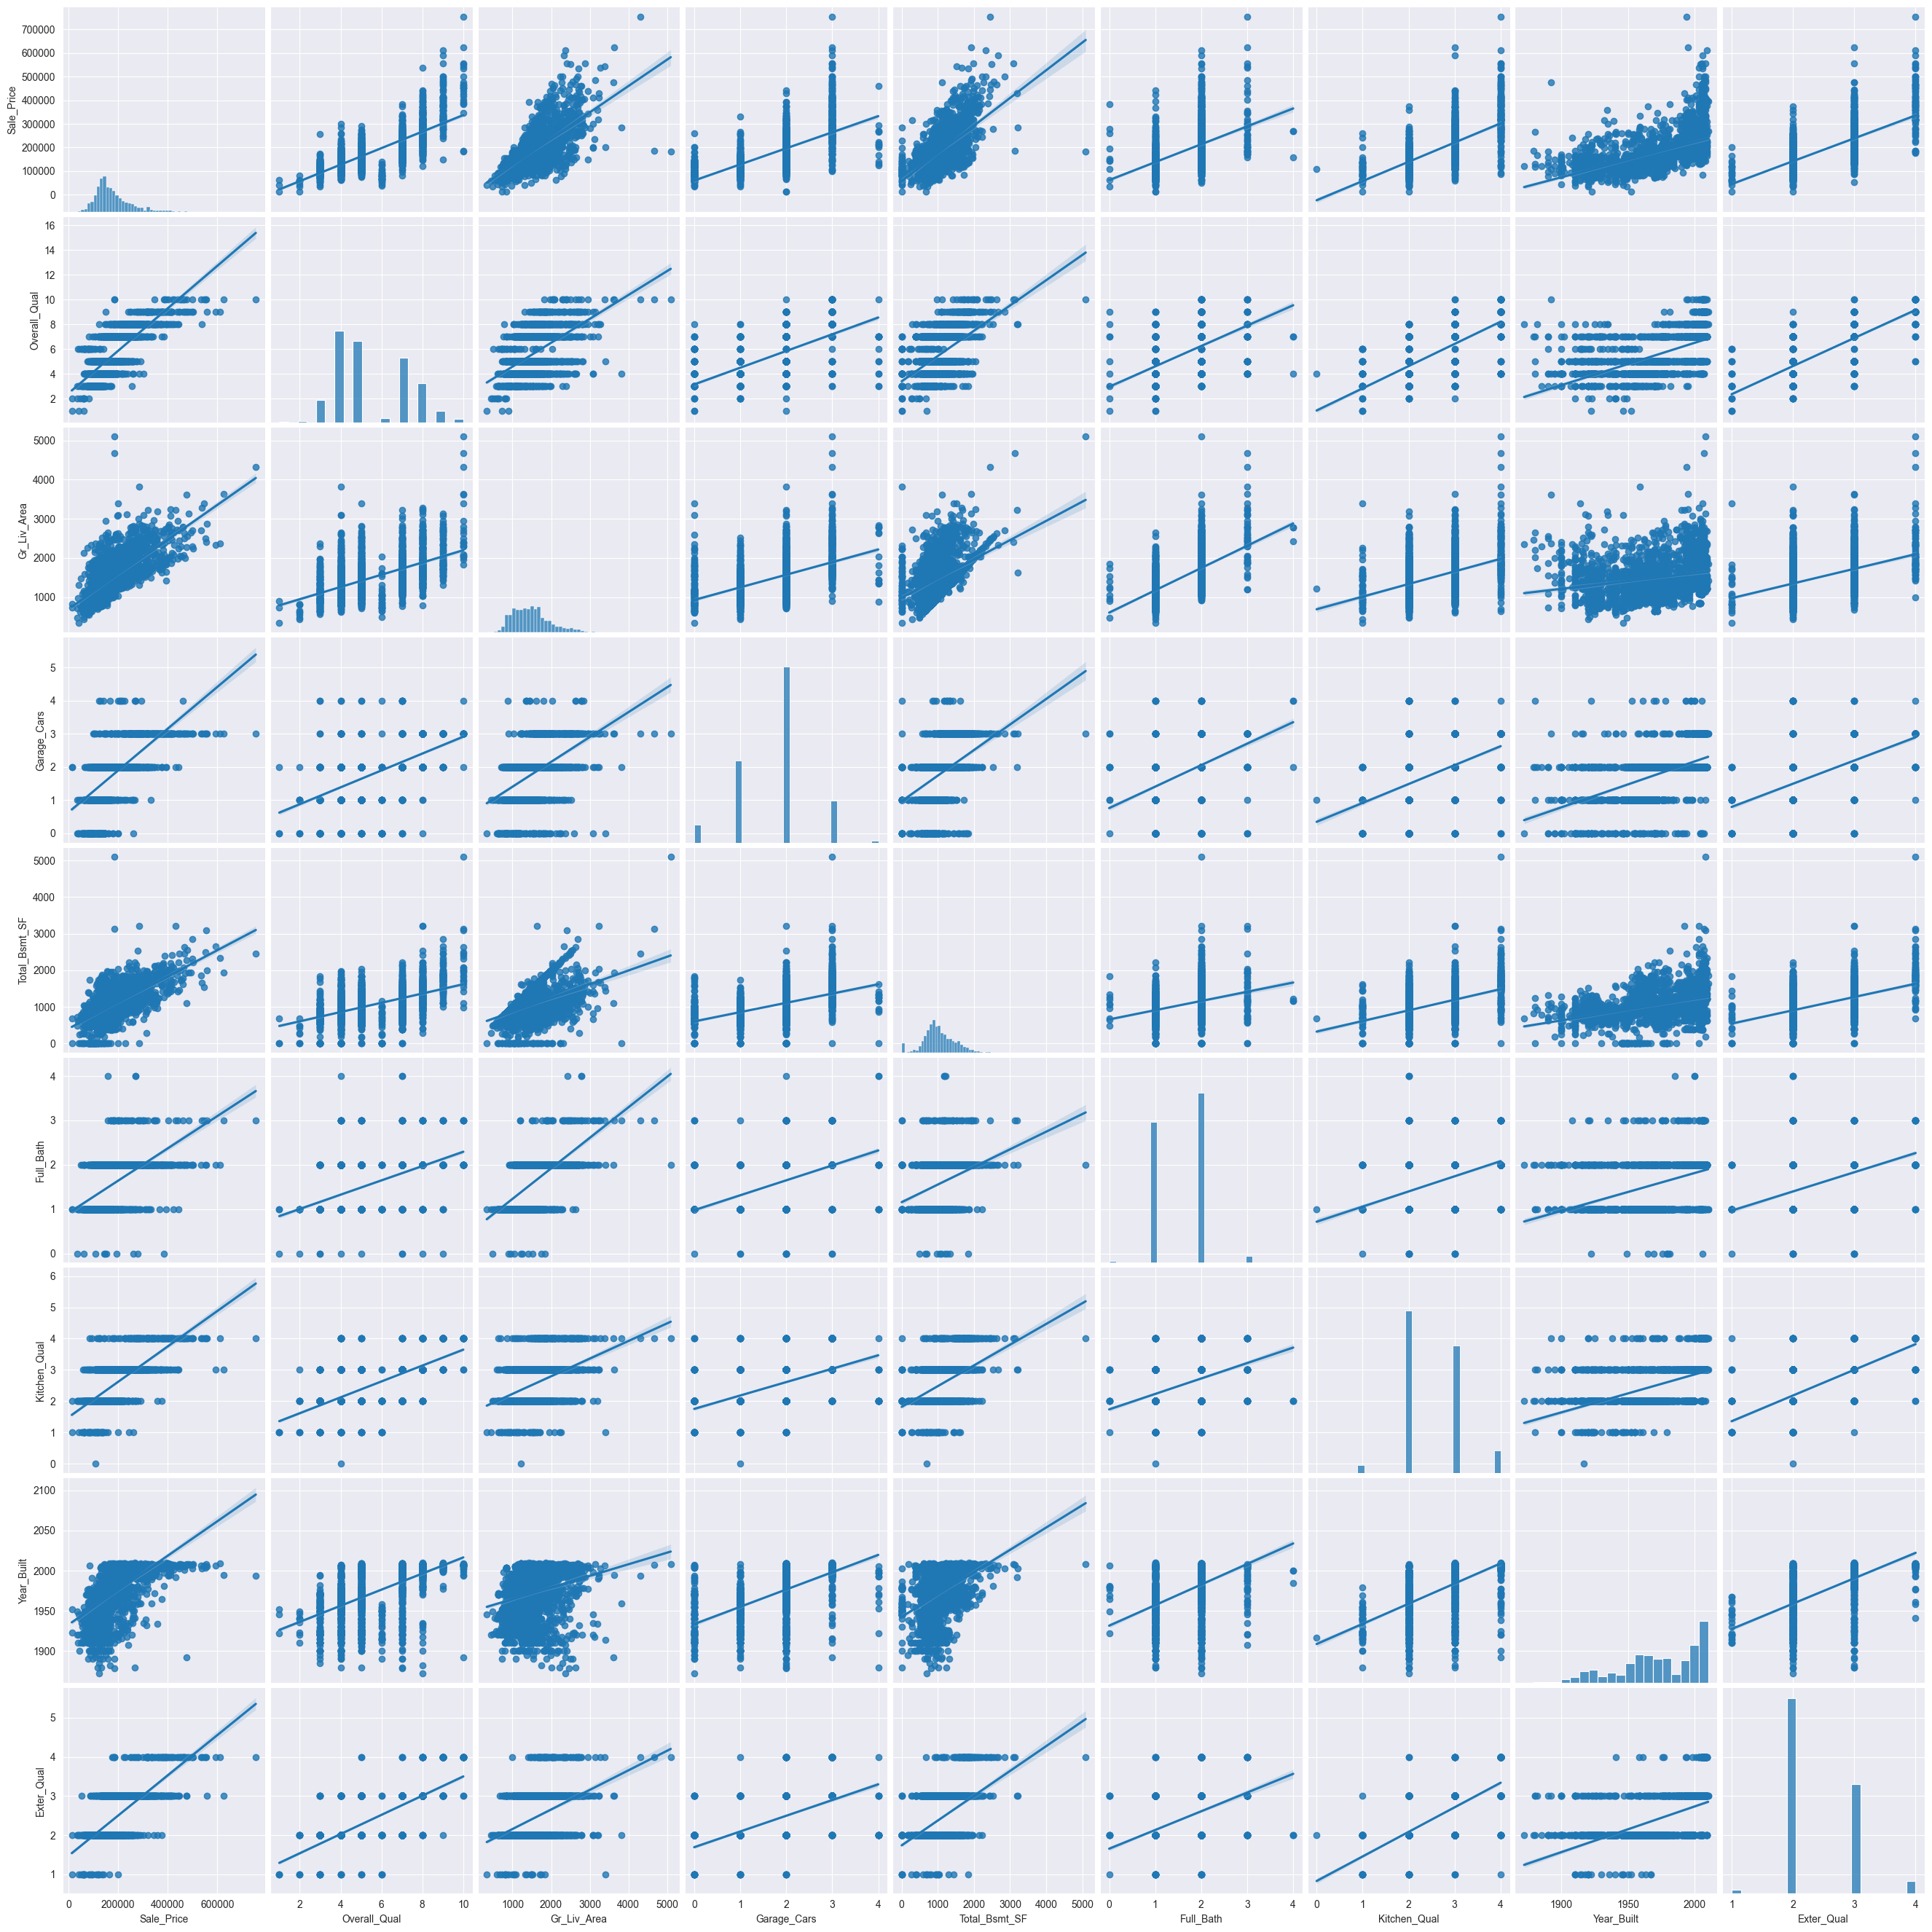

In [78]:
col = ['Sale_Price', 'Overall_Qual', 'Gr_Liv_Area', 'Garage_Cars', 'Total_Bsmt_SF', 'Full_Bath', 'Kitchen_Qual',
       'Year_Built', 'Exter_Qual']
sns.pairplot(XY_train[col], height=3, kind='reg')

# Feature importance

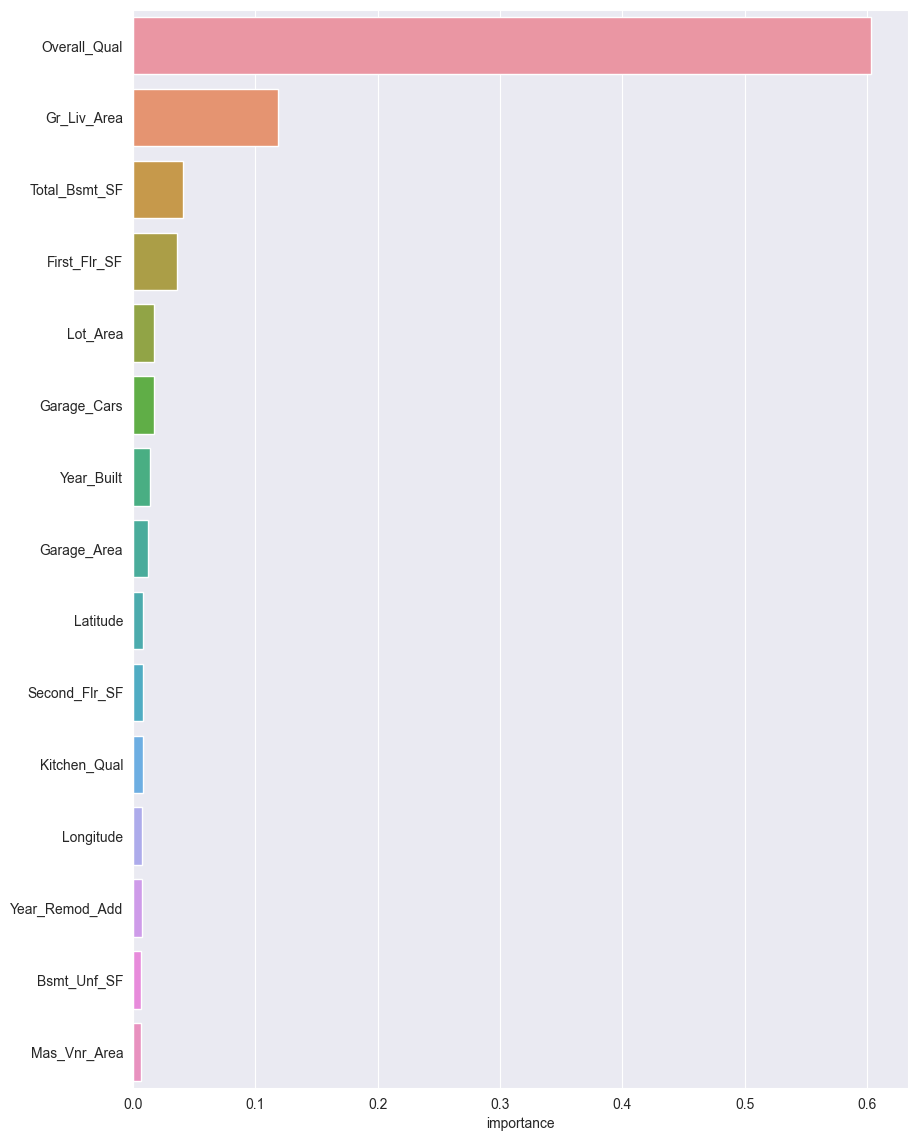

In [79]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=500)
rnd_reg.fit(X_train, Y_train)

feature_importances = pd.DataFrame(rnd_reg.feature_importances_, index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 14))
sns.barplot(x="importance", y=feature_importances.index[:15], data=feature_importances[:15])
plt.show()

# Plot some plot for correlatted features

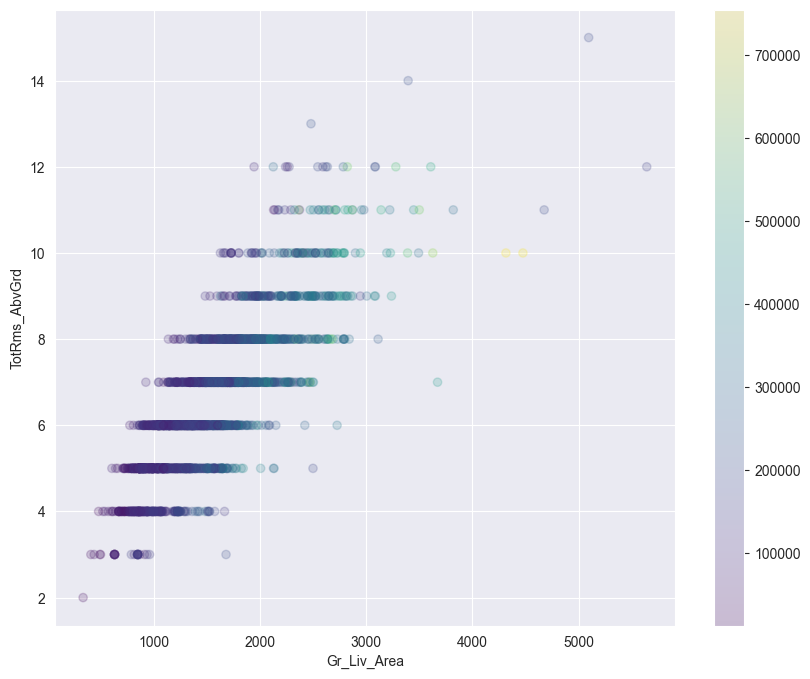

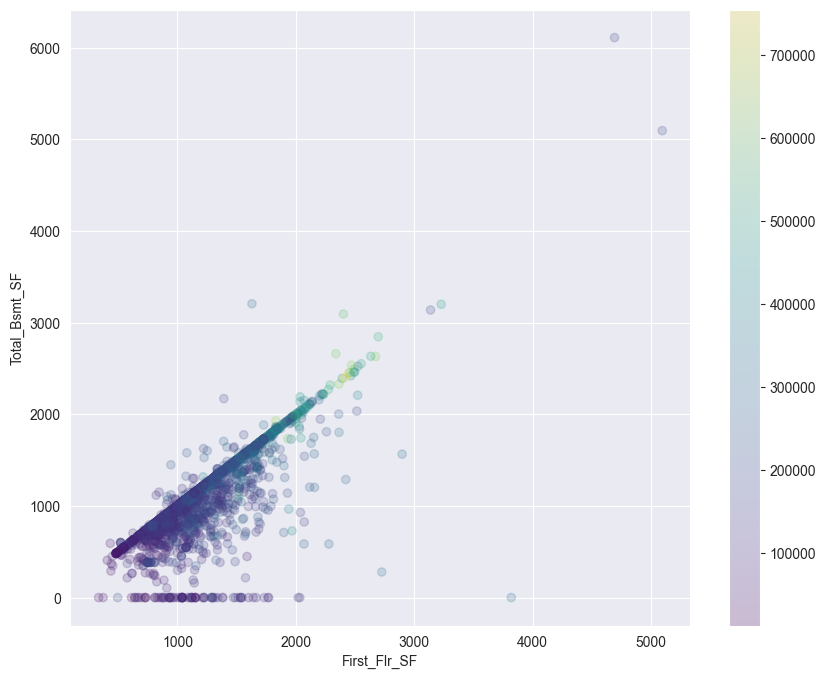

In [80]:
fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.Gr_Liv_Area, data.TotRms_AbvGrd, c=data.Sale_Price, cmap="viridis", alpha=0.2)
axs.set_xlabel('Gr_Liv_Area')
axs.set_ylabel('TotRms_AbvGrd')
fig.colorbar(pos)
plt.show()

fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.First_Flr_SF, data.Total_Bsmt_SF, c=data.Sale_Price, cmap="viridis", alpha=0.2)
axs.set_xlabel('First_Flr_SF')
axs.set_ylabel('Total_Bsmt_SF')
fig.colorbar(pos)
plt.show()


# Save dataframe in a csv file

In [81]:
X_train.to_csv('./data/X_train.csv', index=False)
X_test.to_csv('./data/X_test.csv', index=False)
Y_train.to_csv('./data/Y_train.csv', index=False)
Y_test.to_csv('./data/Y_test.csv', index=False)